In [78]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import models , layers

In [79]:
BATCH_SIZE = 32
IMAGE_SIZE = 256 # all images are of size 256 x 256
CHANNELS = 3

In [80]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/aniruth/Desktop/RRC/Projects/Potato Disease Classifier/Training/PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [81]:
# each data is a tuple : has two elements : its value and its label 
for data in dataset.take(1):
    
    image_batch = data[0]
    label_batch = data[1]

    print(image_batch.shape)
    print(label_batch.numpy())


(32, 256, 256, 3)
[0 0 0 0 0 1 1 0 0 0 2 1 1 0 1 0 0 0 0 0 1 2 1 1 0 0 0 0 0 2 0 1]


2024-03-26 00:33:53.007580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [82]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [83]:
len(dataset) # every batch has 32 images 

68

In [84]:
# each batch has 32 elements in it 

for image_batch , label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())


(32, 256, 256, 3)
[0 0 1 0 1 0 0 0 0 0 0 1 2 1 0 1 1 0 2 0 0 1 0 0 1 1 0 1 0 1 0 0]


2024-03-26 00:33:54.484804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


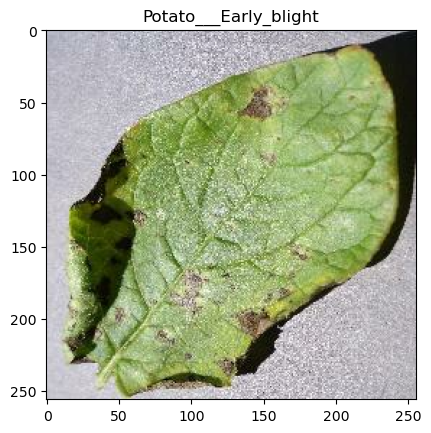

2024-03-26 00:34:34.634436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [93]:
import matplotlib.pyplot as plt

for images_batch, label_batch in dataset.take(1):
    
    for i in range(len(images_batch)):
        
        image = images_batch[i].numpy().astype("uint8") # to convert the values to float 
        label = label_batch[i].numpy()
        
        plt.imshow(image)
        plt.title(class_names[label])
        plt.show()
        # break


### Splitting the dataset 

80 - training , 10 - test , 10 - validation



In [94]:
len(dataset)
train_size = int(0.8*len(dataset))
print(train_size)

54


In [95]:
# trainging dataset 
train_ds = dataset.take(54) # out of 68

In [96]:
# test dataset 

test_ini_ds = dataset.skip(54)
print(len(test_ini_ds))

# split this into 10 percent test and 10 percent validation 
val_size = 0.1*len(dataset)
print(val_size)

test_ds = test_ini_ds.skip(6)
validation_ds = test_ini_ds.take(6)
print(len(test_ds))
print(len(validation_ds))




14
6.800000000000001
8
6


In [97]:
# Creating a wrapper function to split the data 

def get_dataset_partition(ds, train_split = 0.8 , val_split =0.1 , test_split = 0.1 , shuffle = True , shuffle_size  =1000):
   
    ds_size = len(ds)

    if shuffle :
        ds = ds.shuffle(shuffle_size , seed = 12) # seed is a just a specific way of shuffling
        
    train_size = int(train_split*ds_size)

    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    

    return train_ds, val_ds,test_ds
    

In [90]:
train_ds, val_ds,test_ds = get_dataset_partition(dataset)

In [14]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))


54
8
6


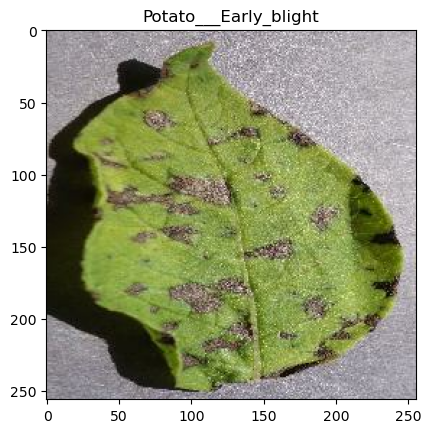

In [101]:
for images_batch, label_batch in train_ds:
    
    # each image batch shape = (32,256,256,3)
    # each label batch shape = (32,1)
    
    for i in range(len(images_batch)):
        
        image = images_batch[i].numpy().astype("uint8") # to convert the values to float 
        label = label_batch[i].numpy()
        
        plt.imshow(image)
        plt.title(class_names[label])
        plt.show()

    #     break
    # break

### Pipeline Performance and pre-processing

In [102]:
# pipeline performace -> Run it parallely using prefetch and caching

# prefetch and Caching to use GPU and boost the performance 
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)




In [103]:
# Create a Sequential model for resizing and rescaling

resize_n_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1/255)
])


In [104]:
# Creating a data augmentation layers -> to add more datas which are distorted 

from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom


data_augmentation = Sequential(
  [
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
  ]
)


### Applying Data Augmentation to the training set 

In [105]:
# augmented input x and the label y 

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


### CNN modeling 

In [33]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([

    # data augmentation already done 

    # normalise the data 
    resize_n_rescale,

    # conv layer and max pool it 
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # flatten the layer 
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [34]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32, 128)              │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (32, 3)                │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,387 (782.76 KB)

 Trainable params: 200,387 (782.76 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy
    metrics=['accuracy']
)

In [107]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard , EarlyStopping

# Define the directory to save models
save_dir = './models_testing/'

callbacks = [
    # Save the model weights after every epoch
    ModelCheckpoint(save_dir + 'model_{epoch:02d}.keras', save_best_only=False),

    EarlyStopping(patience=10, restore_best_weights=True), # if 10 epochs doesnt improve the val_acc it will stop 
    # it will store the best model 
    
    # Log training metrics to TensorBoard for visualization
    TensorBoard(log_dir=save_dir)  # Change log_dir to save_dir]
]

# Train the model
history = model.fit(train_ds, epochs=30, validation_data=val_ds, batch_size=BATCH_SIZE, callbacks=callbacks)


Epoch 1/30
25/54 ━━━━━━━━━━━━━━━━━━━━ 10s 360ms/step - accuracy: 0.9386 - loss: 0.1999

KeyboardInterrupt: 

In [ ]:

# Optionally, you can plot the training history
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
scores = model.evaluate(test_ds)

### Making Predictions 

In [ ]:
for images_batch , label_batch in test_ds.take(1):
    
    first_img = images_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()

    
    print("First image to predict")
    plt.imshow(first_img)

    
    print("Actual label :",class_names[first_label])

    pred = class_names[np.argmax(model.predict(images_batch)[0])] # for the first image 
    print(f"Predicted is :",pred)

In [68]:

def predict(model, img):

    # we pass a single image 
    # model will run for a batch only -> so make a batch and pass 
    # single image represented by img_array into a batch of size 1, where the first dimension represents the batch size.
    img_array = tf.expand_dims(img, 0)  # creates a batch of size = 1

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])] # take the first image of the batch 
    confidence = round(100 * np.max(predictions[0]), 2) 
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-03-26 00:12:31.962608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


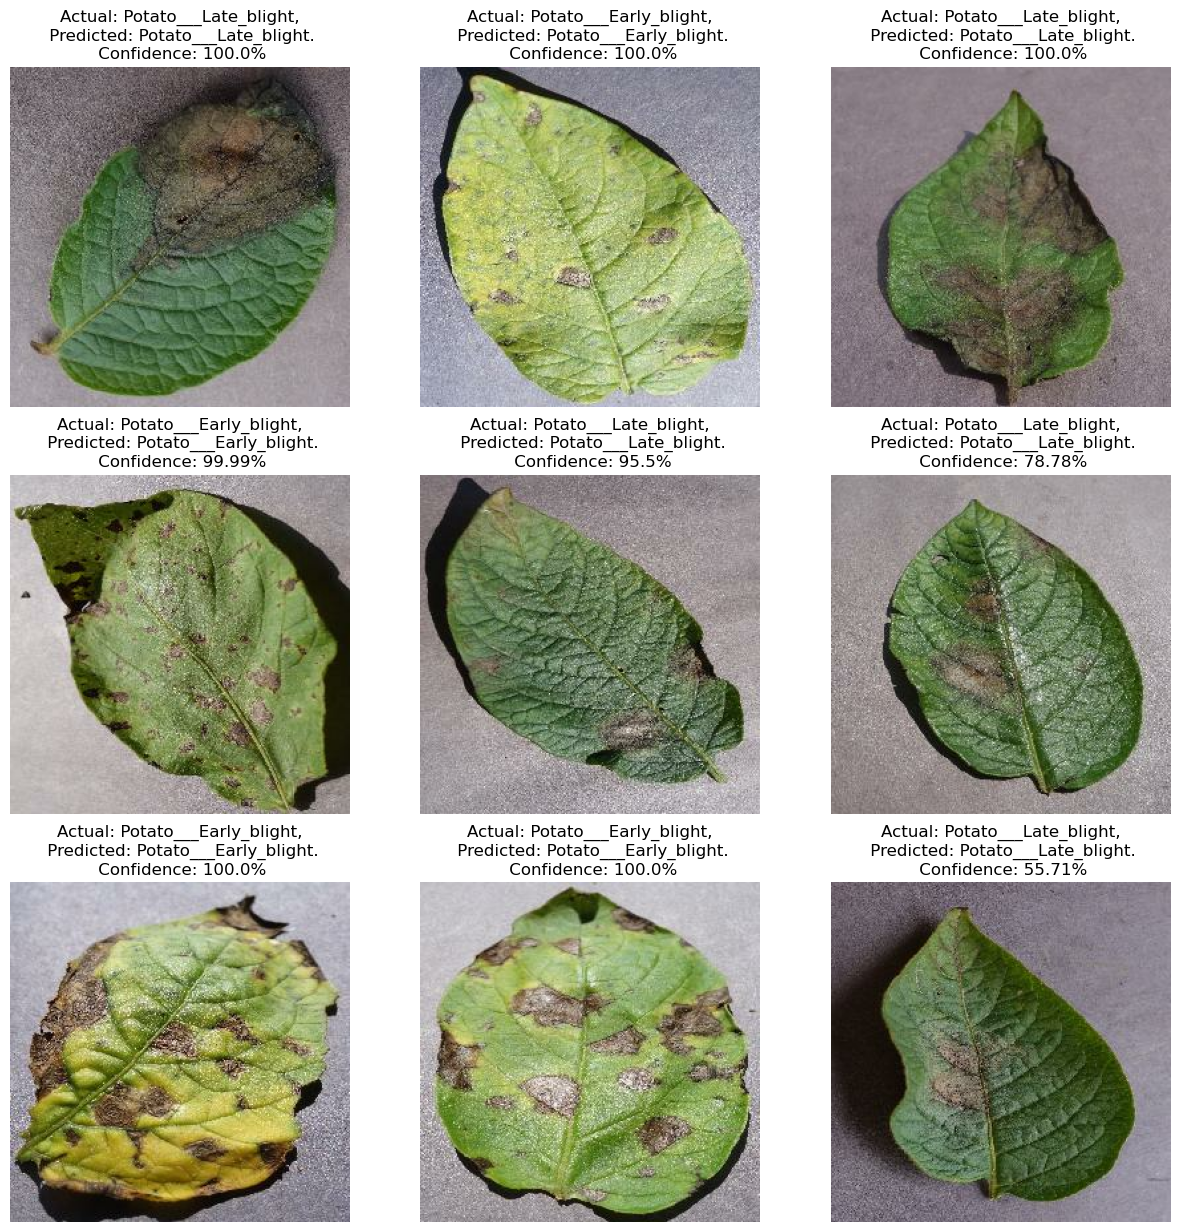

In [70]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


### Saving the model

In [76]:
name = 1
model.save(f"/home/aniruth/Desktop/RRC/Projects/Potato Disease Classifier/final model/{name}.keras")
